# MemAE 3D Memory Input

In [1]:
import os 
import glob as glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Download Fmnist from: https://www.kaggle.com/zalando-research/fashionmnist

## Load Data

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values

X_train, X_valid = X_train/255, X_valid/255

In [4]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_valid = X_valid.reshape(X_valid.shape[0],28,28,1)

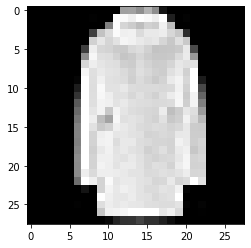

In [5]:
plt.imshow(X_train[6,:,:,0], cmap="gray")
plt.show()

## Model

In [6]:
class Memory(layers.Layer):
    def __init__(self, mem_dim, fea_dim):
        super(Memory, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim

        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1,1,self.mem_dim, self.fea_dim), dtype="float32"),
            trainable=True,
        )
        
    def cosine_sim(self, x1, x2):
        num = tf.linalg.matmul(x1, tf.transpose(x2, perm=[0, 1, 3, 2]))
        denom =  tf.linalg.matmul(x1**2, tf.transpose(x2, perm=[0, 1, 3, 2])**2)
        w = (num + 1e-12) / (denom + 1e-12)
        return w    
        
    def call(self, z):
        cosim = self.cosine_sim(x1=z, x2=self.w) 
        atteniton = tf.nn.softmax(cosim)
        
        lam = 1 / self.mem_dim # deactivate the 1/N of N memories.

        addr_num = tf.keras.activations.relu(atteniton - lam) * atteniton
        addr_denum = tf.abs(atteniton - lam) + 1e-12
        memory_addr = addr_num / addr_denum
        renorm = tf.clip_by_value(memory_addr, 1e-12, 1-(1e-12))
        z_hat = tf.linalg.matmul(renorm, self.w)
        
        return z_hat, renorm

In [7]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.SeparableConv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.SeparableConv2D(64, 3, activation="relu", strides=2, padding="same")(x)
z_hat, att = Memory(100,64)(x)
encoder = keras.Model(encoder_inputs, [z_hat, att], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 14, 14, 32)        73        
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 7, 64)          2400      
_________________________________________________________________
memory (Memory)              ((None, 7, 7, 64), (None, 6400      
Total params: 8,873
Trainable params: 8,873
Non-trainable params: 0
_________________________________________________________________


In [8]:
latent_inputs = keras.Input(shape=(7,7,64))
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 64)]        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 55,681
Trainable params: 55,681
Non-trainable params: 0
_________________________________________________________________


In [9]:
class MemAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(MemAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
    
        with tf.GradientTape() as tape:
            z_hat, w_hat = self.encoder(x)
            x_hat = self.decoder(z_hat)

            mse = tf.reduce_sum(tf.square(x - x_hat), axis=(1, 2, 3))
            mem_etrp = tf.reduce_sum((-w_hat) * tf.math.log(w_hat + 1e-12), axis=(1, 2, 3))
            loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}
    
    def test_step(self, data):
        x, y = data[0],data[1]
        z_hat, w_hat = self.encoder(x)
        x_hat = self.decoder(z_hat)

        mse = tf.reduce_sum(tf.square(x - x_hat), axis=(1, 2, 3))
        mem_etrp = tf.reduce_sum((-w_hat) * tf.math.log(w_hat + 1e-12), axis=(1, 2, 3))
        loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
        
        return {"loss": loss}
    
    def call(self, inputs):
        z_hat, w_hat = self.encoder(inputs)
        x_hat = self.decoder(z_hat)
        return x_hat, w_hat

In [10]:
model = MemAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam())
model.fit(X_train,validation_data=(X_valid,X_valid), epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 74s 39ms/step - loss: 446.8798 - val_loss: 8.9639
Epoch 2/10
1875/1875 [==============================] - 75s 40ms/step - loss: 197.7689 - val_loss: 6.0915
Epoch 3/10
1875/1875 [==============================] - 69s 37ms/step - loss: 144.3987 - val_loss: 5.4052
Epoch 4/10
1875/1875 [==============================] - 69s 37ms/step - loss: 128.7177 - val_loss: 5.1476
Epoch 5/10
1875/1875 [==============================] - 66s 35ms/step - loss: 121.5231 - val_loss: 4.8727
Epoch 6/10
1875/1875 [==============================] - 66s 35ms/step - loss: 117.7474 - val_loss: 5.0465
Epoch 7/10
1875/1875 [==============================] - 70s 37ms/step - loss: 114.3749 - val_loss: 4.9445
Epoch 8/10
1875/1875 [==============================] - 70s 37ms/step - loss: 111.9115 - val_loss: 4.7103
Epoch 9/10
1875/1875 [==============================] - 71s 38ms/step - loss: 110.0144 - val_loss: 4.6661
Epoch 10/10
1875/1875 [=======================

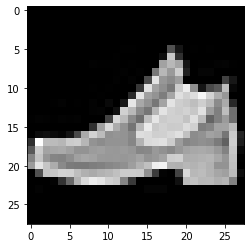

In [11]:
plt.imshow(X_train[1,:,:,0], cmap="gray")
plt.show()

In [12]:
i = X_train[1,:,:,:].reshape(1,28,28,1)
print(i.shape)
xh, _ = model(i)

(1, 28, 28, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



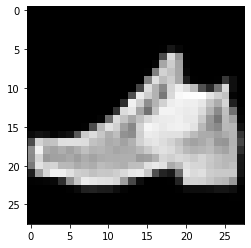

In [13]:
plt.imshow(xh[0,:,:,0], cmap="gray")
plt.show()

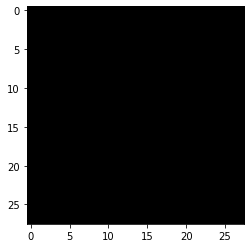

In [14]:
noise = np.ones((1,28,28,1))
plt.imshow(noise[0,:,:,0], cmap="gray")
plt.show()

In [15]:
xh_noise, _ = model(noise)

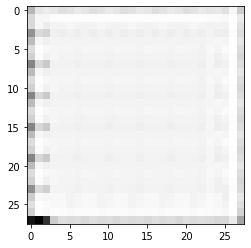

In [16]:
plt.imshow(xh_noise[0,:,:,0], cmap="gray")
plt.show()